In [2]:
pip install yfinance


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------- ----------------------------- 0.8/3.0 MB 3.4 MB/s eta 0:00:01
     ----------------- ---------------------- 1.3/3.0 MB 3.5 MB/s eta 0:00:01
     ------------------------ --------------- 1.8/3.0 MB 3.1 MB/s eta 0:00:01
     --------------------------- ------------ 2.1/3.0 MB 2.9 MB/s eta 0:00:01
     ------------------------------- -------- 2.4/3.0 MB 2.4 MB/s eta 0:00:01
     ---------------------------------- ----- 2.6/3.0 MB 2.1 MB/s eta 0:00:01
     -------------------------------------- - 2.9/3.0 MB 2.0 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 1.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements 

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


[*********************100%***********************]  1 of 1 completed

1. Downloading data for AAPL and calculating indicators...
   Cleaned Dataset Shape: (2460, 8)
2. Preprocessing data and creating sequences...
   X_train sequence shape: (1920, 60, 8)
3. Building and training the LSTM model...



C:\Users\febin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   Training Complete.
4. Evaluating model performance...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
   Root Mean Squared Error (RMSE): $6.8233
   Directional Prediction Accuracy: 51.57%
5. Generating visualization...


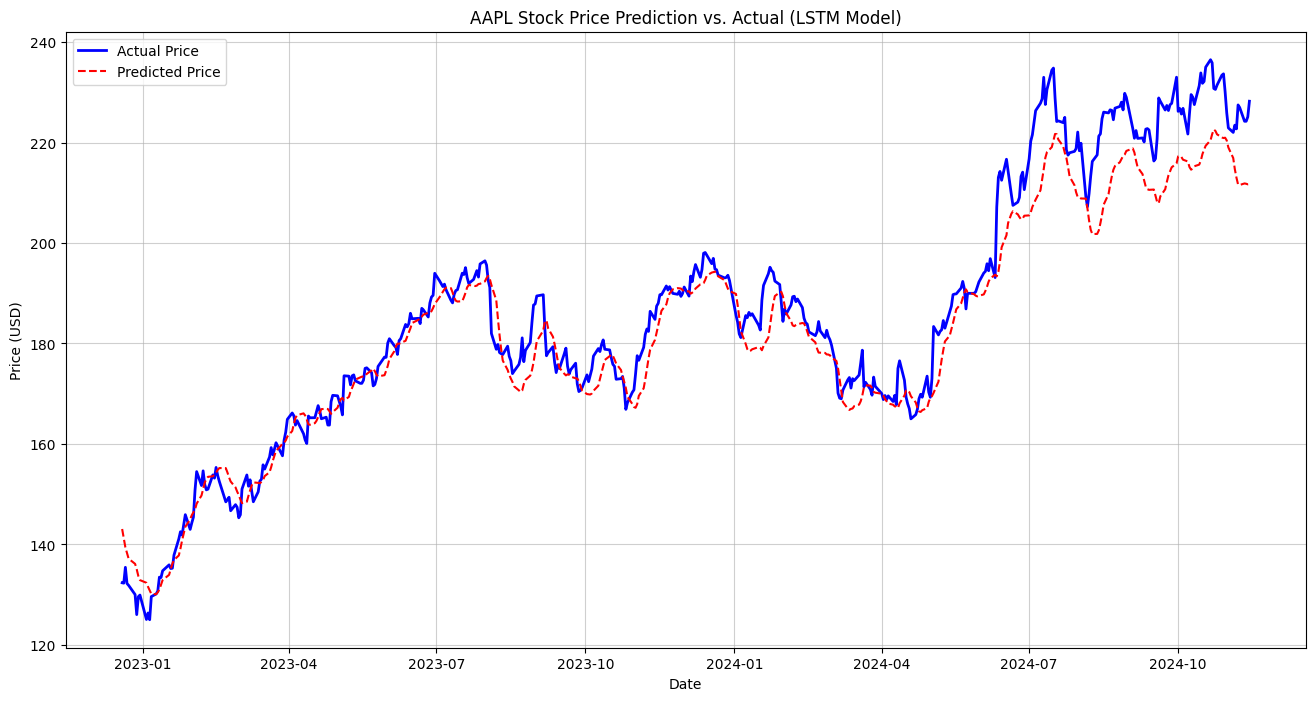

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta # Library for Technical Analysis indicators
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# --- Configuration ---
TICKER = 'AAPL'
START_DATE = '2015-01-01'
END_DATE = '2024-11-15'
TIME_STEP = 60 # Lookback window (60 trading days)
EPOCHS = 25
BATCH_SIZE = 32

# --- 1. Data Collection and Feature Engineering ---
print(f"1. Downloading data for {TICKER} and calculating indicators...")
# Set auto_adjust=False to ensure 'Close' is unadjusted and 'Adj Close' is present (though we don't use it),
# or remove the .drop('Adj Close') line entirely if using the yfinance default.
# We are proceeding with auto_adjust=False for consistent column structure.
data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)

# Calculate Technical Indicators
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# Use .squeeze() to ensure data['Close'] is a 1D Pandas Series for the 'ta' library
close_prices = data['Close'].squeeze()

# Relative Strength Index (RSI)
data['RSI'] = ta.momentum.RSIIndicator(close_prices, window=14).rsi()
# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close_prices).macd()
data['MACD'] = macd

# Select features and clean up NaN values (due to rolling windows/indicators)
FEATURES = ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA_20', 'RSI', 'MACD']
data.dropna(inplace=True)
data_for_model = data[FEATURES].values
print(f"   Cleaned Dataset Shape: {data_for_model.shape}")

# --- 2. Data Preprocessing and Sequence Creation ---
print("2. Preprocessing data and creating sequences...")
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_for_model)

# Function to create time-series sequences (X = 60 days of features, Y = 61st day Close price)
def create_sequences(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        Y.append(data[i + time_step, 0]) # Target is the normalized Close price (index 0)
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, TIME_STEP)

# Split data: 80% Train, 20% Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"   X_train sequence shape: {X_train.shape}")

# --- 3. Model Training (LSTM) ---
print("3. Building and training the LSTM model...")

# Build the Sequential LSTM Model
model = Sequential()
# Input shape: (time_step, number_of_features)
model.add(LSTM(units=50, return_sequences=True, input_shape=(TIME_STEP, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1)) # Output: 1 predicted value (next day's Close price)

# Compile and Train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=0)
print("   Training Complete.")

# --- 4. Evaluation and Backtesting ---
print("4. Evaluating model performance...")
predictions = model.predict(X_test)

# Function to inverse scale the normalized values back to actual prices
def inverse_scale(scaled_values, original_scaler, num_features):
    dummy_array = np.zeros((len(scaled_values), num_features))
    dummy_array[:, 0] = scaled_values.flatten()
    return original_scaler.inverse_transform(dummy_array)[:, 0]

# Inverse transform predictions and actual test values
inverse_predictions = inverse_scale(predictions, scaler, data_for_model.shape[1])
inverse_actual = inverse_scale(y_test, scaler, data_for_model.shape[1])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(inverse_actual, inverse_predictions))
print(f"   Root Mean Squared Error (RMSE): ${rmse:.4f}")

# Calculate Directional Prediction Accuracy (Backtesting direction)
actual_direction = np.sign(np.diff(inverse_actual))
predicted_direction = np.sign(np.diff(inverse_predictions))
correct_direction = np.sum(actual_direction == predicted_direction)
accuracy = correct_direction / len(actual_direction)
print(f"   Directional Prediction Accuracy: {accuracy*100:.2f}%")

# --- 5. Visualization ---
print("5. Generating visualization...")

# CORRECTED INDEX CALCULATION:
# The index starts at the end of the training sequences (len(X_train)) plus the time step.
start_index_for_plot = len(X_train) + TIME_STEP

# Extract the dates for the test set from the original data
plot_data_index = data.iloc[start_index_for_plot:].index

# Prepare data for plotting
plot_df = pd.DataFrame({
    'Actual Price': inverse_actual,
    'Predicted Price': inverse_predictions
}, index=plot_data_index)

# Plotting
plt.figure(figsize=(16, 8))
plt.plot(plot_df['Actual Price'], label='Actual Price', color='blue', linewidth=2)
plt.plot(plot_df['Predicted Price'], label='Predicted Price', color='red', linestyle='--', linewidth=1.5)
plt.title(f'{TICKER} Stock Price Prediction vs. Actual (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()